# Import Libraries & Data Preprocessing

## Imports

In [2]:
# Pip install all necessary libraries

%pip install coinbase
%pip install cbpro
%pip install bta-lib
%pip install finta
%pip install ccxt

     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 1.9 MB 45.7 MB/s 
  Created wheel for coinbase: filename=coinbase-2.1.0-py2.py3-none-any.whl size=20987 sha256=139a0f0642f34e038d9676db66e237b896a26de0211b241e8687d4884be05427
  Stored in directory: /root/.cache/pip/wheels/d1/42/80/6215bd14fcc7488d4703658af55974906654c44ce965e68879
Successfully built coinbase
     |████████████████████████████████| 196 kB 42.3 MB/s 
     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 584 kB 51.6 MB/s 
  Created wheel for pymongo: filename=pymongo-3.5.1-cp37-cp37m-linux_x86_64.whl size=362244 sha256=29cf6417cd3a0aa243c5a6b9bcad95d8ad8307c110805d59dc205475c774a9cc
  Stored in directory: /root/.cache/pip/wheels/96/bd/a9/81eacd9925ebaa01c560bbe29d42a0e1b678bcfb6247e9e3be
  Created wheel for websocket-client: filename=websocket_client-0.40.0-py2.py3-none-any.whl size=198296 sha256=ca17d8d48880db8f771e72c65c67291e063c5

     |████████████████████████████████| 92 kB 26 kB/s 
     |████████████████████████████████| 2.0 MB 35.0 MB/s 
     |████████████████████████████████| 62 kB 727 kB/s 
     |████████████████████████████████| 3.5 MB 56.2 MB/s 
     |████████████████████████████████| 1.3 MB 70.1 MB/s 
     |████████████████████████████████| 294 kB 70.6 MB/s 
     |████████████████████████████████| 160 kB 64.2 MB/s 
     |████████████████████████████████| 291 kB 68.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.13.0
    Uninstalling requests-2.13.0:
      Successfully uninstalled requests-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.10.0 which is incompatible.
google-api-core 1

In [5]:
# Import libraries and dependencies

import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cbpro
import time
import btalib
from finta import TA
from datetime import datetime, timedelta
from coinbase.wallet.client import Client
from coinbase.wallet.model import APIObject
#from dotenv import load_dotenv
from pathlib import Path

%matplotlib inline

In [6]:
# Set option to be able to display all rows so I can look at all the data
pd.set_option('display.max_rows', None)

## API keys

In [7]:
# API info for Chafic's Coinbase Pro sandbox account (paper trading)

API_key_sandbox = "af3d88450eec041694a6c5f5be0af84b"
API_secret_sandbox = "ohGzn353EgeG961seV+W5Dsk81KYHdwwZstWJYJxK8duy3OhSRJdUVh0ehyOU3975zS6r4ORNuuEftEkN4laWA=="
API_pass_sandbox = "s9y6pvgno4"

In [8]:
# Set API_url and coinbase pro client

API_url = 'https://api-public.sandbox.pro.coinbase.com'
client = cbpro.AuthenticatedClient(
    API_key_sandbox,
    API_secret_sandbox,
    API_pass_sandbox,
    API_url)

## Bring in and prepare historical price data

In [9]:
# Variables for currency pairs
BTC = "BTC-USD"

# 1 day candlesticks (86,400 seconds) (Coinbase Pro uses seconds as the units)
timeframe = "86400"

# Set variables for beginning and end of the date column
endTime = datetime.now()

delta = timedelta(seconds = int(timeframe))
startTime = endTime # coinbase pro only allows 300 bars so this allows us to capture all of it

# Convert times to iso format so coinbase can read them
endTimeISO = endTime.isoformat()
startTimeISO = startTime.isoformat()

# Parameters for the data request - end time (now), start time (300 days ago), and granularity (how much time each candlestick is worth)
parameters = {
    "start":startTimeISO,
    "end":endTimeISO,
    "granularity":timeframe,
    }

# Run a loop to gather data points in groups of 300 going back as far as possible
# "years" in this case is 300 data points (or 300 days)

historical_returns=list()
years=9
for i in range(years):
  print(i)
  endTime0 = endTime - delta*300*(range(years).index(np.max([0,(years-1)-(i+1)])))
  print(endTime0)
  startTime0 = startTime - (300*delta*(range(years).index((years-1)-(i)))) 
  print(startTime0)
  endTimeISO = endTime0.isoformat()
  startTimeISO = startTime0.isoformat()

  parameters = {
    "start":startTimeISO,
    "end":endTimeISO,
    "granularity":timeframe,
    }

  data = requests.get(f"{API_url}/products/{BTC}/candles",
                           params = parameters,
                           headers = {"content-type":"application/json"})
  print(data.text)
  print("***************")
  if len(data.text) > 0:
    historical_returns.append(data)
  

print(len(historical_returns))
print("***************")
print(historical_returns[7].text)

0
2016-01-11 02:07:08.502641
2015-03-17 02:07:08.502641
[]
***************
1
2016-11-06 02:07:08.502641
2016-01-11 02:07:08.502641
[[1478390400,705.86,719.83,706.98,717.02,3013.17627869],[1478304000,697.72,707.99,706.05,706.99,2999.21458017],[1478217600,683.8,708.33,690,706.32,5229.21994603],[1478131200,672.06,746.16,744.61,690,10331.34963833],[1478044800,720,744.6,730.7,744.6,5096.8408538],[1477958400,695.74,737.5,697.07,730.7,6909.18196562],[1477872000,681.01,709.68,697.39,696.9,4474.8670547],[1477785600,692.04,714.98,714.28,697.41,3799.52235609],[1477699200,689.39,725.64,689.95,714.28,6583.49896892],[1477612800,683.2,691.19,691.01,689.95,4409.98654001],[1477526400,673.54,692.41,674,691.21,6771.85374768],[1477440000,652.51,678,654.3,674,5843.50141279],[1477353600,648.99,657.5,649.98,654.3,4814.88839172],[1477267200,645.81,652.93,651.05,649.98,3670.49141848],[1477180800,645.33,655.8,653.03,651.04,3075.73956709],[1477094400,629.32,658,630.67,652.75,4586.7845212],[1477008000,627.5,633.4

In [10]:

df = list()
for i in range(len(historical_returns)):
    # Create a temporary dataframe out of each group of 300 data points
    data = historical_returns[i]
    df_tmp = pd.DataFrame(data.json(),
                  columns=['Time', 'Low', 'High', 'Open', 'Close', 'Volume'])

    # Create date column from the time column given
    df_tmp["Date"] = pd.to_datetime(df_tmp["Time"], unit='s')

    # Put columns in the preferred order
    df_tmp = df_tmp[["Date", "Open", "High", "Low", "Close"]]
    
    print("***************")
    df.append(df_tmp)
    print(i)


df = pd.concat(df,ignore_index=True)
print(df.head())
print(df.tail())
print(df['Date'])

***************
0
***************
1
***************
2
***************
3
***************
4
***************
5
***************
6
***************
7
***************
8
        Date    Open    High     Low   Close
0 2016-11-06  706.98  719.83  705.86  717.02
1 2016-11-05  706.05  707.99  697.72  706.99
2 2016-11-04  690.00  708.33  683.80  706.32
3 2016-11-03  744.61  746.16  672.06  690.00
4 2016-11-02  730.70  744.60  720.00  744.60
           Date     Open      High      Low    Close
1685 2020-02-24  9970.02  10014.51  9513.97  9669.00
1686 2020-02-23  9675.00  20000.00  4174.70  9970.00
1687 2020-02-22  9691.03   9723.94  9585.09  9675.02
1688 2020-02-21  9622.25   9913.57  9579.99  9691.03
1689 2020-02-20  9606.00  13000.00  3500.00  9622.25
0      2016-11-06
1      2016-11-05
2      2016-11-04
3      2016-11-03
4      2016-11-02
5      2016-11-01
6      2016-10-31
7      2016-10-30
8      2016-10-29
9      2016-10-28
10     2016-10-27
11     2016-10-26
12     2016-10-25
13     2016-10-2

In [11]:
df_full = df.iloc[::-1]

df_full = df

In [12]:
# Set datetime as the index
df_full.set_index('Date', inplace=True)

df_full = df_full.sort_index()

display(df_full.head())
display(df_full.tail())

,Open,High,Low,Close
Date,,,,
2016-05-01,454.02,457.07,451.55,456.98
2016-05-02,456.98,457.63,440.02,446.42
2016-05-03,446.53,453.29,443.61,452.21
2016-05-04,452.21,453.23,446.76,448.68
2016-05-05,448.59,451.56,447.00,449.98


,Open,High,Low,Close
Date,,,,
2020-12-11,18243.70,18945.92,17572.58,18028.01
2020-12-12,18028.01,22080.00,17629.61,18809.58
2020-12-13,18809.60,19935.83,18243.55,19169.25
2020-12-14,19169.23,22000.00,16578.00,19272.37
2020-12-15,19272.37,21000.00,18795.01,19434.98


# Add Indicators and Fib Levels

## Moving Averages

In [14]:
# Define a function that calculates the Simple Moving Average
def get_sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [15]:
# Add a column for the 20 SMA
df_full['20sma'] = get_sma(df_full['Close'], 20)
display(df_full.tail())

# Add column for the 55 SMA
df_full['55sma'] = get_sma(df_full['Close'], 55)
display(df_full.tail())

,Open,High,Low,Close,20sma
Date,,,,,
2020-12-11,18243.70,18945.92,17572.58,18028.01,18589.1315
2020-12-12,18028.01,22080.00,17629.61,18809.58,18607.3195
2020-12-13,18809.60,19935.83,18243.55,19169.25,18646.1765
2020-12-14,19169.23,22000.00,16578.00,19272.37,18651.6480
2020-12-15,19272.37,21000.00,18795.01,19434.98,18687.3000


,Open,High,Low,Close,20sma,55sma
Date,,,,,,
2020-12-11,18243.70,18945.92,17572.58,18028.01,18589.1315,16152.717818
2020-12-12,18028.01,22080.00,17629.61,18809.58,18607.3195,16285.526545
2020-12-13,18809.60,19935.83,18243.55,19169.25,18646.1765,16420.240727
2020-12-14,19169.23,22000.00,16578.00,19272.37,18651.6480,16553.904182
2020-12-15,19272.37,21000.00,18795.01,19434.98,18687.3000,16673.989455


## Trend

In [16]:
# Create a reference vector following whether price is trending up or down based on the 20 and 55 SMA
# Using list comprehension to create the list based on the 20sma and 55sma columns
reference_vector = ["Uptrend" if df_full['20sma'].iloc[x] > df_full['55sma'].iloc[x]  else "Downtrend" for x in range(df_full.shape[0])]

# Display the list
print(reference_vector)
print(reference_vector[50])
print(reference_vector[150])
print(reference_vector[1000])

['Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 

In [17]:
# Add the reference vector to the dataframe and name the column Trend
df_full['Trend'] = reference_vector


## Average True Range

In [18]:
# Define a function to calculate True Range (volatility) 
# True range is the maximum value out of (high-low), (high-previous_close), and (previous_close-low)

def trueRange(df):
  df_full['previous_close'] = df_full['Close'].shift(1)
  df_full['high-low'] = df_full['High'] - df_full['Low']
  df_full['high-pc'] = abs(df_full['High'] - df_full['previous_close'])
  df_full['low-pc'] = abs(df_full['Low'] - df_full['previous_close'])

  TR = df_full[['high-low', 'high-pc', 'low-pc']].max(axis=1)

  return TR


# Add a column to the dataframe with the True Range and print top 5 rows

df_full['TR'] = trueRange(df_full)

df_full.head()

,Open,High,Low,Close,20sma,55sma,Trend,previous_close,high-low,high-pc,low-pc,TR
Date,,,,,,,,,,,,
2016-05-01,454.02,457.07,451.55,456.98,NaN,NaN,Downtrend,NaN,5.52,NaN,NaN,5.52
2016-05-02,456.98,457.63,440.02,446.42,NaN,NaN,Downtrend,456.98,17.61,0.65,16.96,17.61
2016-05-03,446.53,453.29,443.61,452.21,NaN,NaN,Downtrend,446.42,9.68,6.87,2.81,9.68
2016-05-04,452.21,453.23,446.76,448.68,NaN,NaN,Downtrend,452.21,6.47,1.02,5.45,6.47
2016-05-05,448.59,451.56,447.00,449.98,NaN,NaN,Downtrend,448.68,4.56,2.88,1.68,4.56


In [20]:
# Define a function to calculate Average True Range using the True Range
# Set default period to 14 days

period = 14

def ATR(df, period=14):
  ATR = df_full['TR'].rolling(period).mean()

  return ATR

df_full['ATR'] = ATR(df_full, 14)

df_full.tail()

,Open,High,Low,Close,20sma,55sma,Trend,previous_close,high-low,high-pc,low-pc,TR,ATR
Date,,,,,,,,,,,,,
2020-12-11,18243.70,18945.92,17572.58,18028.01,18589.1315,16152.717818,Uptrend,18243.70,1373.34,702.22,671.12,1373.34,5336.844286
2020-12-12,18028.01,22080.00,17629.61,18809.58,18607.3195,16285.526545,Uptrend,18028.01,4450.39,4051.99,398.40,4450.39,5136.603571
2020-12-13,18809.60,19935.83,18243.55,19169.25,18646.1765,16420.240727,Uptrend,18809.58,1692.28,1126.25,566.03,1692.28,4901.766429
2020-12-14,19169.23,22000.00,16578.00,19272.37,18651.6480,16553.904182,Uptrend,19169.25,5422.00,2830.75,2591.25,5422.00,4360.480714
2020-12-15,19272.37,21000.00,18795.01,19434.98,18687.3000,16673.989455,Uptrend,19272.37,2204.99,1727.63,477.36,2204.99,4101.253571


In [21]:
# Drop unnecessary columns
df_full = df_full.drop(columns=['previous_close', 'high-low', 'high-pc', 'low-pc', 'TR'])


In [22]:
# Check the dataframe
print(df_full.head(20))
print(df_full.tail())

              Open    High     Low   Close    20sma  55sma      Trend       ATR
Date                                                                           
2016-05-01  454.02  457.07  451.55  456.98      NaN    NaN  Downtrend       NaN
2016-05-02  456.98  457.63  440.02  446.42      NaN    NaN  Downtrend       NaN
2016-05-03  446.53  453.29  443.61  452.21      NaN    NaN  Downtrend       NaN
2016-05-04  452.21  453.23  446.76  448.68      NaN    NaN  Downtrend       NaN
2016-05-05  448.59  451.56  447.00  449.98      NaN    NaN  Downtrend       NaN
2016-05-06  449.99  463.73  448.84  462.31      NaN    NaN  Downtrend       NaN
2016-05-07  462.31  464.00  459.55  461.91      NaN    NaN  Downtrend       NaN
2016-05-08  461.91  465.00  457.50  462.79      NaN    NaN  Downtrend       NaN
2016-05-09  462.60  465.90  459.41  464.16      NaN    NaN  Downtrend       NaN
2016-05-10  464.15  465.00  448.20  452.78      NaN    NaN  Downtrend       NaN
2016-05-11  452.77  458.65  452.50  454.

## Bollinger Bands (2 standard deviations)

In [23]:
# Define a function that calculates the Bollinger bands (2 standard deviations)

def bb(data, window=20):
    sma = get_sma(data, window)
    std = df_full['Close'].rolling(window).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

BBup, BBdown = bb(df_full['Close'])

In [24]:
# Add a column to the dataframe with the standard deviation

df_full['std'] = df_full['Close'].rolling(window=20).std()


# Add two columns to the dataframe, 

df_full['Upperband'] = df_full['20sma'] + (2 * df_full['std'])
df_full['Lowerband'] = abs(df_full['20sma'] - (2 * df_full['std']))


# Print bottom 50 rows of the dataframe

df_full.tail(50)

,Open,High,Low,Close,20sma,55sma,Trend,ATR,std,Upperband,Lowerband
Date,,,,,,,,,,,
2020-10-27,13069.99,15000.00,11806.00,13780.01,12011.1620,11104.611636,Uptrend,1840.530714,870.756921,13752.675843,10269.648157
2020-10-28,13780.01,16000.00,11587.63,13286.62,12128.7710,11160.365818,Uptrend,2063.043571,876.505022,13881.781044,10375.760956
2020-10-29,13286.62,16000.00,10722.97,13460.00,12248.9175,11214.599636,Uptrend,2388.155714,886.503599,14021.924699,10475.910301
2020-10-30,13459.98,16000.00,11840.57,13569.31,12362.2580,11276.452182,Uptrend,2629.713571,903.871582,14170.001164,10554.514836
2020-10-31,13582.07,16000.00,13000.00,13814.68,12484.2915,11341.230182,Uptrend,2715.915000,927.865262,14340.022024,10628.560976
2020-11-01,13814.68,16000.00,13000.00,13766.56,12595.5625,11403.062182,Uptrend,2802.116429,942.136374,14479.835248,10711.289752
2020-11-02,13766.58,16000.00,11072.00,13575.90,12702.9945,11465.993273,Uptrend,3108.220714,924.237842,14551.470184,10854.518816
2020-11-03,13575.92,15500.00,12540.45,14024.26,12832.8655,11535.068909,Uptrend,3291.954286,917.947908,14668.761315,10996.969685
2020-11-04,14024.26,15500.00,13000.00,14172.05,12966.3185,11604.598182,Uptrend,3259.625000,908.399144,14783.116787,11149.520213


In [25]:
# Drop standard deviation column

df_full.drop(columns='std')

,Open,High,Low,Close,20sma,55sma,Trend,ATR,Upperband,Lowerband
Date,,,,,,,,,,
2016-05-01,454.02,4.570700e+02,451.55,456.98,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-02,456.98,4.576300e+02,440.02,446.42,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-03,446.53,4.532900e+02,443.61,452.21,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-04,452.21,4.532300e+02,446.76,448.68,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-05,448.59,4.515600e+02,447.00,449.98,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-06,449.99,4.637300e+02,448.84,462.31,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-07,462.31,4.640000e+02,459.55,461.91,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-08,461.91,4.650000e+02,457.50,462.79,NaN,NaN,Downtrend,NaN,NaN,NaN
2016-05-09,462.60,4.659000e+02,459.41,464.16,NaN,NaN,Downtrend,NaN,NaN,NaN


## Entries & Exits

In [26]:
# Create Entries and Exits lists (empty) to fill with indices of trade entries and exits

Entries = []
Exits = []
takeProfit = 0
stopLoss = 0


# Add Actual Returns column (daily percentage returns)

df_full['Actual Returns'] = df_full['Close'].pct_change()


# Run a loop to fill the Entries and Exits lists

for x in range(df_full.shape[0]):

  if df_full['Trend'].iloc[x] == "Uptrend":                           # If we are in an uptrend we can look for buys

    if df_full['Close'].iloc[x] <= df_full['Lowerband'].iloc[x]:      # If the daily Close price is less than or equal to the value of the lower Bollinger band, enter a trade (Buy)
      
      if x > 0:
        if len(Exits) > 0:
          if Exits[-1] < x:
            Entries.append(x) 
            entry=x
            exits=[y for y in range(entry+1,df_full.shape[0]) if df_full['Close'].iloc[y]/df_full['Close'].iloc[entry]-1 < -0.02 or df_full['Close'].iloc[y]/df_full['Close'].iloc[entry]-1 > 0.05]       
            Exits.append(min(exits, default=None))
        else:
            Entries.append(x) 
            entry=x
            exits=[y for y in range(entry+1,df_full.shape[0]) if df_full['Close'].iloc[y]/df_full['Close'].iloc[entry]-1 < -0.02 or df_full['Close'].iloc[y]/df_full['Close'].iloc[entry]-1 > 0.05]       
            Exits.append(min(exits, default=None))  

df_full.head()
df_full.tail()


,Open,High,Low,Close,20sma,55sma,Trend,ATR,std,Upperband,Lowerband,Actual Returns
Date,,,,,,,,,,,,
2020-12-11,18243.70,18945.92,17572.58,18028.01,18589.1315,16152.717818,Uptrend,5336.844286,714.032202,20017.195904,17161.067096,-0.011823
2020-12-12,18028.01,22080.00,17629.61,18809.58,18607.3195,16285.526545,Uptrend,5136.603571,714.822062,20036.963623,17177.675377,0.043353
2020-12-13,18809.60,19935.83,18243.55,19169.25,18646.1765,16420.240727,Uptrend,4901.766429,723.576441,20093.329382,17199.023618,0.019122
2020-12-14,19169.23,22000.00,16578.00,19272.37,18651.6480,16553.904182,Uptrend,4360.480714,728.089406,20107.826812,17195.469188,0.005379
2020-12-15,19272.37,21000.00,18795.01,19434.98,18687.3000,16673.989455,Uptrend,4101.253571,748.873408,20185.046816,17189.553184,0.008437


In [29]:
# Check the Entries and Exits lists
# Make sure the length of the lists are the same (Every trade has an entry and exit)

print(Entries)
print(f"Length of Entries: {len(Entries)}")
print(Exits)
print(f"Length of Exits: {len(Exits)}")


[255, 320, 435, 500, 625, 740, 829, 1089, 1093, 1267, 1273, 1396, 1586]
Length of Entries: 13
[261, 321, 439, 501, 626, 746, 831, 1090, 1094, 1268, 1274, 1399, 1598]
Length of Exits: 13


In [30]:
# Calculate returns from our strategy
# We'll do this based on the closing prices from exit locations

strategy_returns = [df_full['Close'].iloc[Exits[x]]/df_full['Close'].iloc[Entries[x]]-1 for x in range(len(Exits))]

# Print length of strategy_returns to double check that we have the same amount of trades as Entries/Exits

len(strategy_returns)

13

In [37]:
# Print the mean and standard deviation of the strategy returns (this is how well our strategy is performing)

print(np.mean(strategy_returns))
print(np.std(strategy_returns))

print(f"The average return of this strategy is {np.mean(strategy_returns).round(3)*100}% with a standard deviation of {np.std(strategy_returns).round(3)*100}%")

0.2411915844898319
0.8812710968100222
The average return of this strategy is 24.099999999999998% with a standard deviation of 88.1%


In [38]:
# Create a list idx with the indices that are trade exits

idx = [True if x in Exits else False for x in range(df_full.shape[0])]

In [39]:
# Create a new dataframe df_filtered with only the indices (dates) where we exit trades

df_filtered = df_full[idx]

In [40]:
# Fill column Returns in filtered dataframe with the percent returns from the strategy

df_filtered['Returns'] = strategy_returns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Print first and last 5 rows of the filtered dataframe
print(df_filtered.head())
print(df_filtered.tail())

                Open      High      Low  ...     Lowerband  Actual Returns   Returns
Date                                     ...                                        
2017-01-17    834.40    909.00   830.10  ...    749.298182        0.085797  0.138520
2017-03-18   1068.78   1096.00   919.44  ...   1043.182298       -0.093093 -0.093093
2017-07-14   2340.00   2349.28  2150.00  ...   2250.788786       -0.052462 -0.048823
2017-09-14   3855.61   3923.00  3230.05  ...   3671.234526       -0.156905 -0.156905
2018-01-17  11570.01  12358.89  9005.00  ...  11271.493281       -0.031979 -0.031979

[5 rows x 13 columns]
                Open         High  ...  Actual Returns   Returns
Date                               ...                          
2019-04-30   1117.36      1656.37  ...        0.247208  0.247208
2019-10-21   6800.00     20000.00  ...        0.888889  0.888889
2019-10-27   6800.00  10000001.00  ...       -0.818179 -0.818179
2020-02-29   8736.33      8781.15  ...       -0.020134 -0

In [42]:
# Create a binary_returns column with a value of 1 for any index (day) with positive returns and 0 for any index with negative returns
binary_returns = []

for x in range(df_filtered.shape[0]):
  if df_filtered['Returns'].iloc[x] > 0:
    binary_returns.append(1)
  else:
    binary_returns.append(0)

df_filtered['Binary Returns'] = binary_returns

df_filtered.tail(60)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Open,High,Low,Close,20sma,55sma,Trend,ATR,std,Upperband,Lowerband,Actual Returns,Returns,Binary Returns
Date,,,,,,,,,,,,,,
2017-01-17,834.40,909.00,830.10,906.00,922.3065,841.452545,Uptrend,8.922929e+01,86.504159,1095.314818,749.298182,0.085797,0.138520,1
2017-03-18,1068.78,1096.00,919.44,970.00,1205.4515,1089.442364,Uptrend,1.186800e+02,81.134601,1367.720702,1043.182298,-0.093093,-0.093093,0
2017-07-14,2340.00,2349.28,2150.00,2217.24,2474.3525,2502.199636,Downtrend,1.281886e+02,111.781857,2697.916214,2250.788786,-0.052462,-0.048823,0
2017-09-14,3855.61,3923.00,3230.05,3250.40,4390.3085,3782.944000,Uptrend,3.412514e+02,359.536987,5109.382474,3671.234526,-0.156905,-0.156905,0
2018-01-17,11570.01,12358.89,9005.00,11200.01,14284.4105,14250.921455,Uptrend,1.696624e+03,1506.458609,17297.327719,11271.493281,-0.031979,-0.031979,0
2018-05-17,8344.01,8483.48,8001.00,8059.00,9049.6320,8279.977818,Uptrend,4.397407e+02,512.073511,10073.779022,8025.484978,-0.034156,-0.040975,0
2018-08-10,6546.46,6584.80,6015.00,6146.01,7466.8720,6885.122545,Uptrend,3.800214e+02,691.671985,8850.215969,6083.528031,-0.061169,-0.021725,0
2019-04-26,602.64,2916.82,602.64,2437.49,4869.4035,4371.555091,Uptrend,6.572621e+02,1190.641212,7250.685923,2488.121077,3.044687,3.044687,1
2019-04-30,1117.36,1656.37,0.01,1393.58,4171.7390,4223.349636,Downtrend,9.584750e+02,1723.700326,7619.139652,724.338348,0.247208,0.247208,1


# Visualize The Data

In [43]:
for x in range(df_full.shape[0]):
  if df_full['Close'].iloc[x]-15000 > df_full['Close'].iloc[x-1]:
    df_full['Close'].iloc[x] = df_full['Close'].iloc[x-1]
  if df_full['Close'].iloc[x]+5000 < df_full['Close'].iloc[x-1]:
    df_full['Close'].iloc[x] = df_full['Close'].iloc[x-2]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<function matplotlib.pyplot.show>

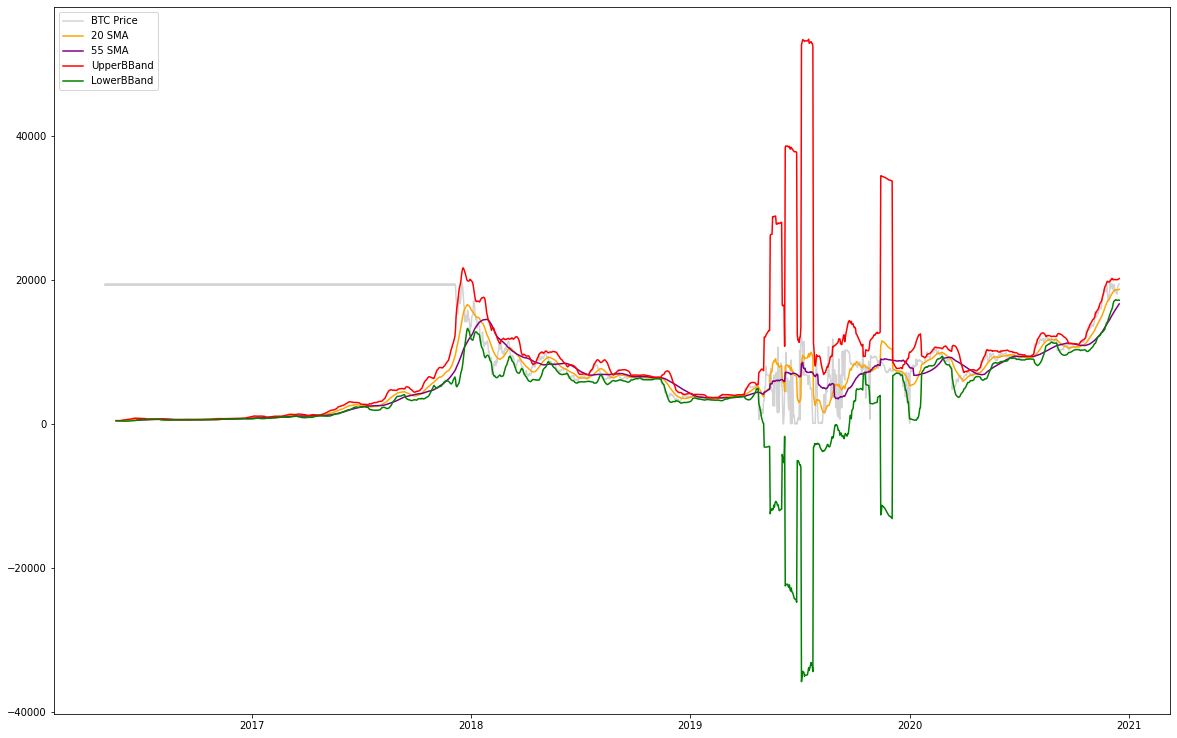

In [44]:
# Plot the chart
import datetime as dt
# Time delta for fib lines
timeD = dt.timedelta(days=30)

plt.figure(figsize=(20, 13))
#plt.style.use("dark_background")
plt.plot(df_full['Close'], label="BTC Price", color="lightgray")
plt.plot(df_full['20sma'], label="20 SMA", color="orange")
plt.plot(df_full['55sma'], label="55 SMA", color="purple")
#plt.plot(df_full['RSI'], label="RSI", color="red")
plt.plot(df_full['Upperband'], label="UpperBBand", color="red")
plt.plot(df_full['Lowerband'], label="LowerBBand", color="green")
#plt.plot(df_full['Fib 0'], label="0% Fib", color="black")
#plt.plot(df_full['Fib 100'], label="100% Fib", color="black")
#plt.plot(df_full['Entry 1'], label="50% Fib (Entry1)", color="green")
#plt.plot(df_full['Entry 2'], label="22.4% Fib (Entry2", color="yellow")
#plt.plot(df_full['TakeProfit 1'], label="161.8% Fib (TakeProfit1)", color="cyan")
#plt.plot(df_full['TakeProfit 2'], label="261.8% Fib (TakeProfit2)", color="cyan")

#plt.plot_date(dates, pivots, linestyle="-", linewidth=2)

plt.legend(loc="upper left")

plt.show

# Train & Test Data

## Build X and y datasets

In [45]:
# Set the X and y datasets to the appropriate columns

X = df_filtered[['20sma', '55sma', 'ATR', 'Upperband', 'Lowerband']]

y = df_filtered['Binary Returns']

print(X.head())
print(y.head())

                 20sma         55sma          ATR     Upperband     Lowerband
Date                                                                         
2017-01-17    922.3065    841.452545    89.229286   1095.314818    749.298182
2017-03-18   1205.4515   1089.442364   118.680000   1367.720702   1043.182298
2017-07-14   2474.3525   2502.199636   128.188571   2697.916214   2250.788786
2017-09-14   4390.3085   3782.944000   341.251429   5109.382474   3671.234526
2018-01-17  14284.4105  14250.921455  1696.623571  17297.327719  11271.493281
Date
2017-01-17    1
2017-03-18    0
2017-07-14    0
2017-09-14    0
2018-01-17    0
Name: Binary Returns, dtype: int64


## Split into training and test datasets

In [46]:
# Training data indices - the first 50/60 trades

train_idx = [True if x <= 49 else False for x in range(X.shape[0])]

In [47]:
# Test data indices - the last 10/60 trades

test_idx = [True if x > 49 else False for x in range(X.shape[0])]

In [48]:
# Import the neccessary Date function
from pandas.tseries.offsets import DateOffset

# Use the following code to select the start of the training period: `training_begin = X.index.min()`
# training_begin = X.index.min()
# print(training_begin)

# Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
# training_end = X.index.min() + Datyearst5months=1
# print(training_end)

# Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# Hint: Use `loc[training_begin:training_end]` for X_train and y_train
# X_train = X.loc[training_begin:training_end]
# y_train = y.loc[training_begin:training_end]

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

# Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# Hint: Use `loc[training_end:]` for X_test and y_test
# X_test = X.loc[training_end:]
# y_test = y.loc[training_end:]

# Use StandardScaler to scale the X_train and X_test data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from imblearn.over_sampling import RandomOverSampler
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

ValueError: ignored

## Train and generate predictions

In [37]:
# Create the classifier model.
from sklearn.svm import SVC
model = SVC()
 
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Fit a SKLearn linear regression using just the training set:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model_rf.fit(X_resampled, y_resampled)

# Make a prediction of "y" values from the X_test dataset
predictions = model_rf.predict(X_resampled)

training_report_rf = classification_report(y_resampled, predictions)
print(training_report_rf)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        26
           1       0.68      0.65      0.67        26

    accuracy                           0.67        52
   macro avg       0.67      0.67      0.67        52
weighted avg       0.67      0.67      0.67        52

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.91      0.81      0.86        26

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.86        52
weighted avg       0.87      0.87      0.86        52



In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,penalty='l1', solver='liblinear').fit(X_resampled, y_resampled)

training_signal_predictions = clf.predict(X_resampled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.65      0.65      0.65        26
           1       0.65      0.65      0.65        26

    accuracy                           0.65        52
   macro avg       0.65      0.65      0.65        52
weighted avg       0.65      0.65      0.65        52



In [39]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions_logreg = clf.predict(X_test_scaled)
testing_signal_predictions_rf = model_rf.predict(X_test_scaled)

In [40]:
# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report_logreg = classification_report(y_test, testing_signal_predictions_logreg)

training_report_rf = classification_report(y_test, testing_signal_predictions_rf)

print(training_report_logreg)
print(training_report_rf)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Create a new empty predictions DataFrame and fill columns with their appropriate values
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns RF'] = testing_signal_predictions_rf
predictions_df['predicted_returns RF'].value_counts()
predictions_df['Binary Returns'] = y_test
predictions_df['Actual Returns'] = df_filtered['Returns'].tail(10)
predictions_df['Predicted Returns Numeric'] = df_filtered['Returns']*-1

print(df_filtered['Returns'].tail())

print(predictions_df['predicted_returns RF'].value_counts())
print(predictions_df.head(10))


Date
2021-04-24   -0.031216
2021-04-26    0.100366
2021-09-10   -0.041963
2021-09-15    0.061961
2021-09-21   -0.054198
Name: Returns, dtype: float64
0    10
Name: predicted_returns RF, dtype: int64
            predicted_returns RF  ...  Predicted Returns Numeric
Date                              ...                           
2021-01-22                     0  ...                  -0.070725
2021-01-27                     0  ...                   0.052441
2021-03-01                     0  ...                  -0.097396
2021-03-26                     0  ...                  -0.073092
2021-04-21                     0  ...                   0.044079
2021-04-24                     0  ...                   0.031216
2021-04-26                     0  ...                  -0.100366
2021-09-10                     0  ...                   0.041963
2021-09-15                     0  ...                  -0.061961
2021-09-21                     0  ...                   0.054198

[10 rows x 4 columns

## Visualize Return Predictions

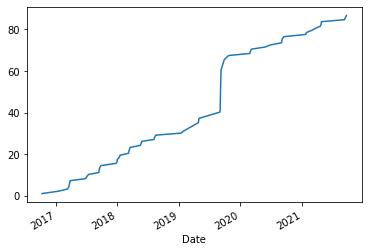

In [180]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1+df_filtered['Returns']).cumsum().plot()

# Go Live (To be continued..)

This section, with more time, will be used to automate the strategy in a way that every day we can press 'Run all' and enter trades through a Coinbase Pro account if the Entry requirements are satisfied or exit a trade if the exit requirements are satisfied

## Get Account History

In [ ]:
accounts = client.get_accounts()

for acc in accounts:
    currency = acc.get('currency')
    if currency == 'BTC':
        acc_id = acc.get('id')

acc_history = client.get_account_history(acc_id)

for hist in acc_history:
    print(json.dumps(hist, indent=1))

## Place A Trade

In [ ]:
# Place buy order worth 1 bitcoin
client.place_market_order(product_id='BTC-USD',side='sell', size=1)

# Place buy order worth $50,000
client.place_market_order(product_id='BTC-USD',side='buy', funds=50000)